In [1]:
from utils import *

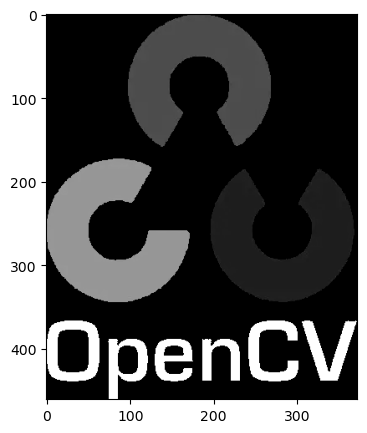

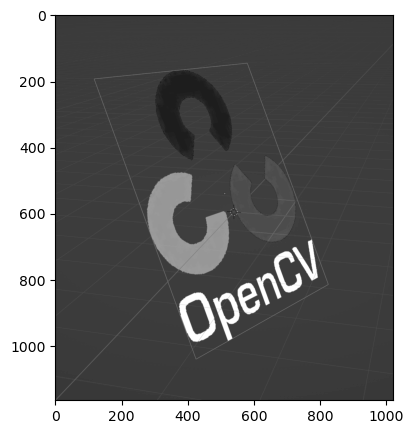

In [2]:
img1 = readImage('./input/opencv.png')  #索引图像 # left image
img2 = cv.imread('./input/perspect_test.png') #训练图像 # right image
img1 = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
img2 = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)
showImage(img1, cmap='gray')
showImage(img2, cmap='gray')

In [3]:
sift = cv.SIFT().create()
# 使用SIFT查找关键点和描述符
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN 参数
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
good = []
pts1 = []
pts2 = []
# 根据Lowe的论文进行比率测试
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [4]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# 我们只选择内点
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [5]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - 我们在img2相应位置绘制极点生成的图像
        lines - 对应的极点 '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

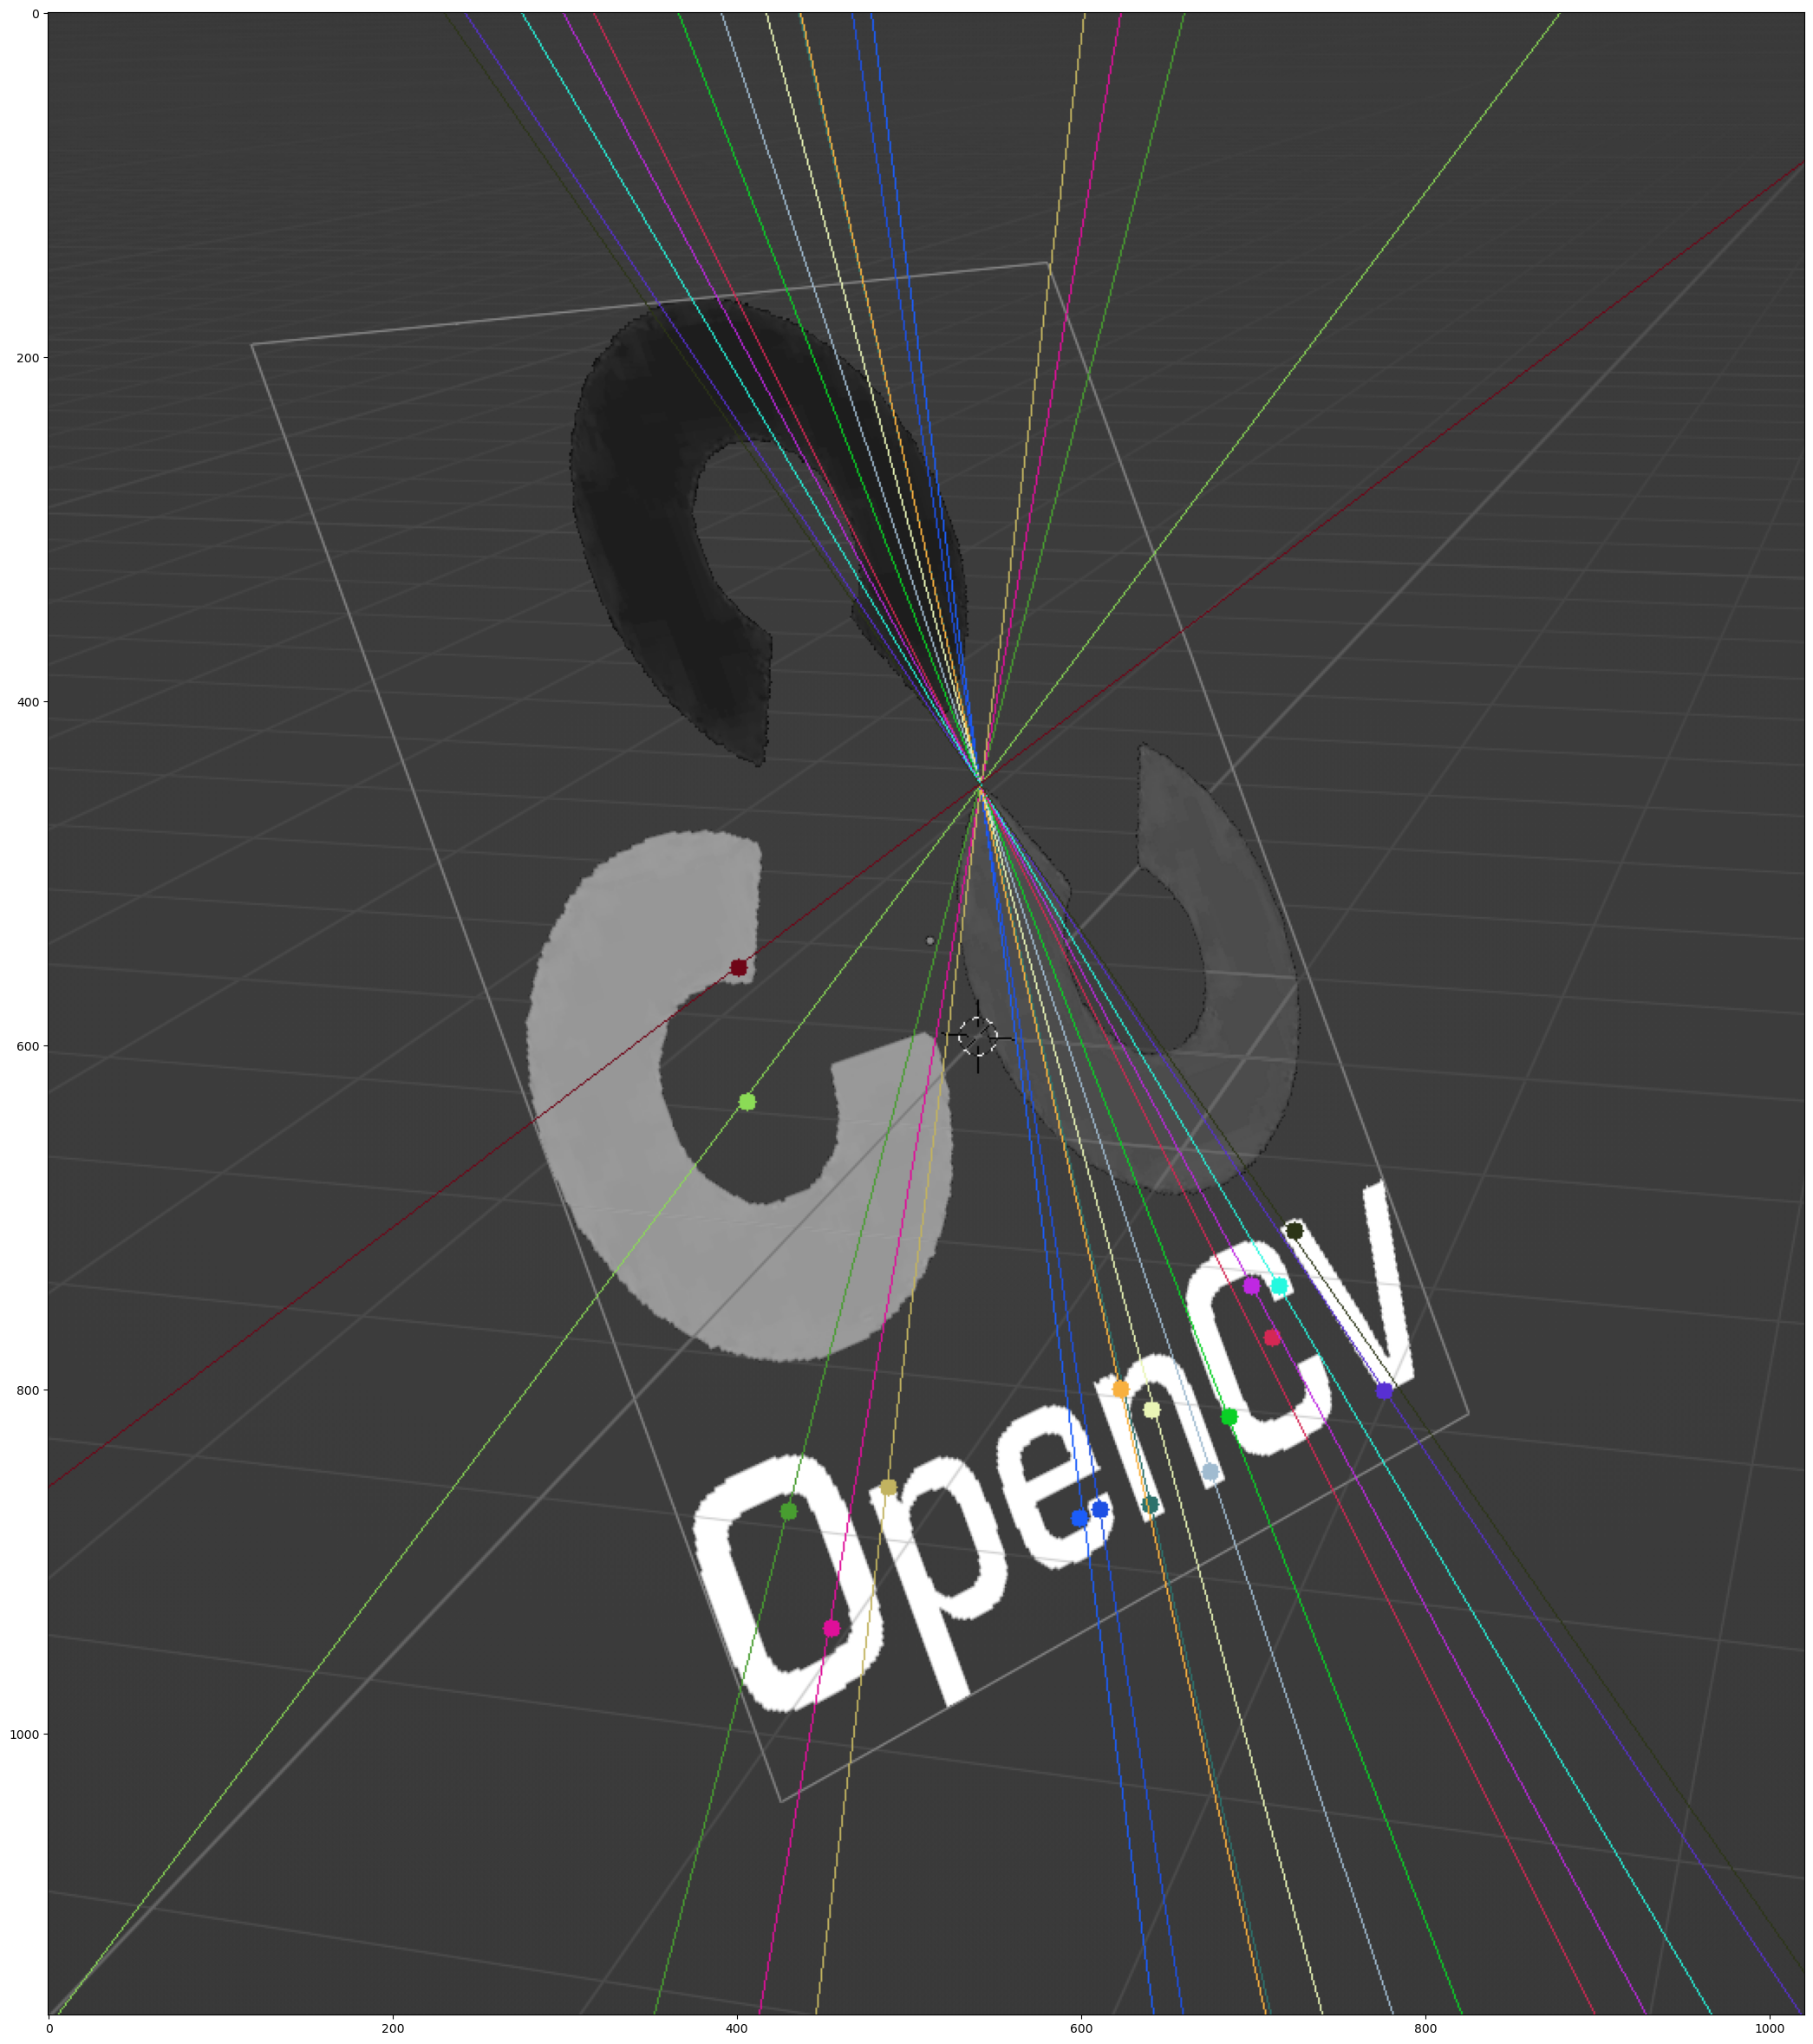

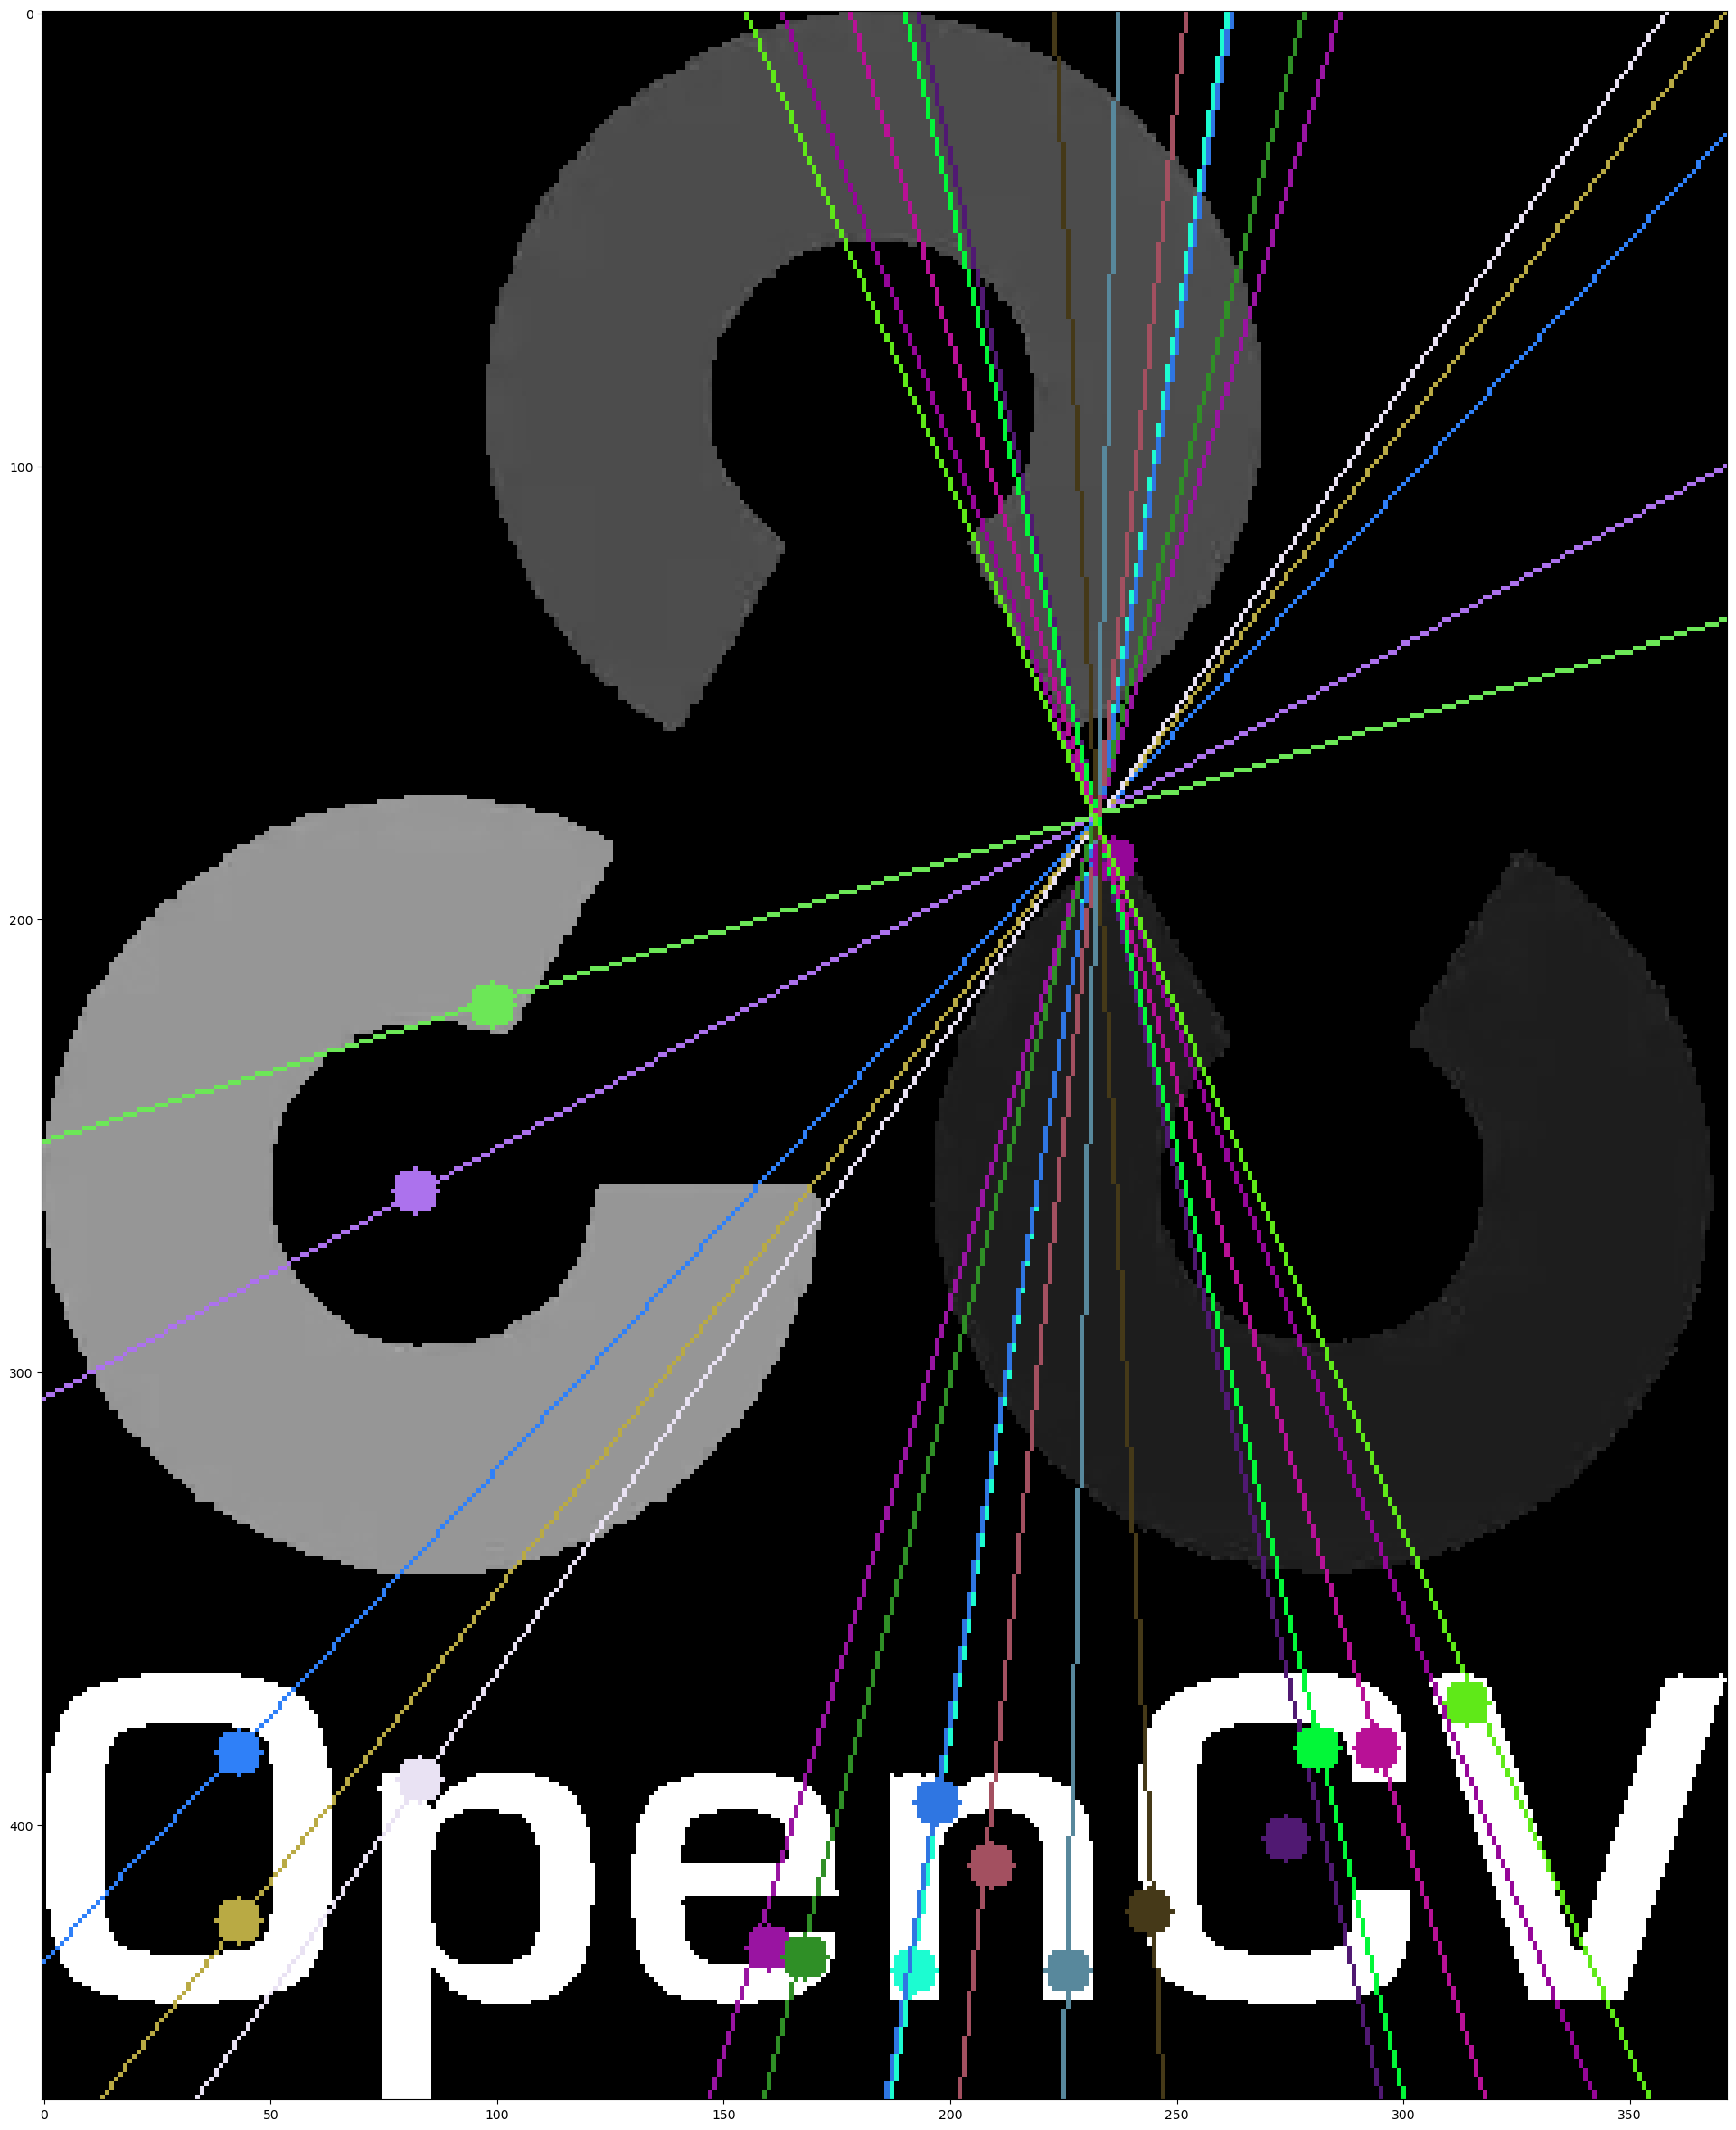

In [6]:
# 在右图（第二张图）中找到与点相对应的极点，然后在左图绘制极线
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# 在左图（第一张图）中找到与点相对应的Epilines，然后在正确的图像上绘制极线
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
showImage(img3, figsize=(30, 30))
showImage(img5, figsize=(30, 30))

In [7]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(img1, img1)

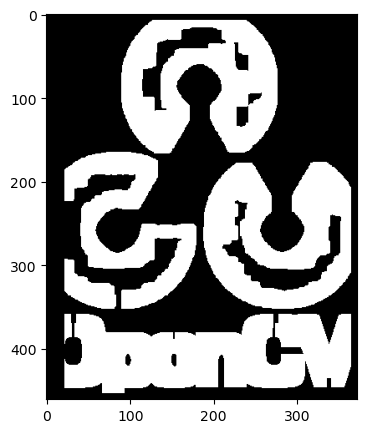

In [8]:
showImage(disparity, cmap='gray')